In [30]:
#Eager Mode
import tensorflow as tf

tf.enable_eager_execution()    
import tensorflow.contrib.eager as tfe
print("Eager execution: {}".format(tf.executing_eagerly())) 

Eager execution: True
Eager execution: True


In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.keras import models
from tensorflow.python.keras.preprocessing import image as kp_image
import IPython.display
from scipy.optimize import fmin_l_bfgs_b
import time
import urllib

# Style Transfer: Alpha Version

This document is for **1 to 1** neural style transfer. In this case, we would implement the algorithm shown in [Gatys' paper](https://arxiv.org/abs/1508.06576).  (Note: Implementation is based on **tensorflow eager execution**). This notebook could be run end-to-end. 

In [32]:
web1='http://www.columbia.edu/~hl3099/aml/central_park.jpg' 
web2='http://www.columbia.edu/~hl3099/aml/starry_night.jpg' 
urllib.request.urlretrieve(web1,'central_park.jpg')
urllib.request.urlretrieve(web2,'starry_night.jpg')

('starry_night.jpg', <http.client.HTTPMessage at 0x7f62a742ab70>)

('starry_night.jpg', <http.client.HTTPMessage at 0x7f62a0683f28>)

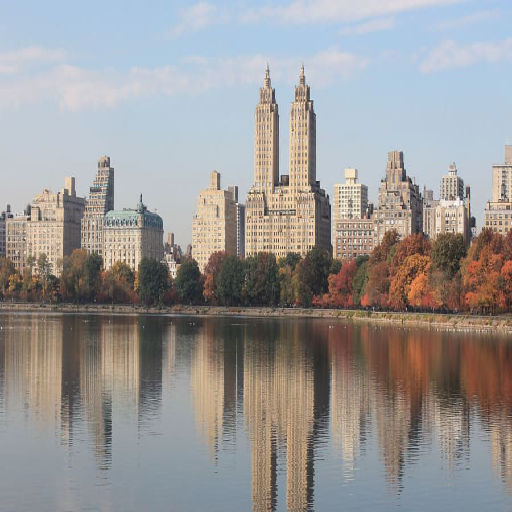

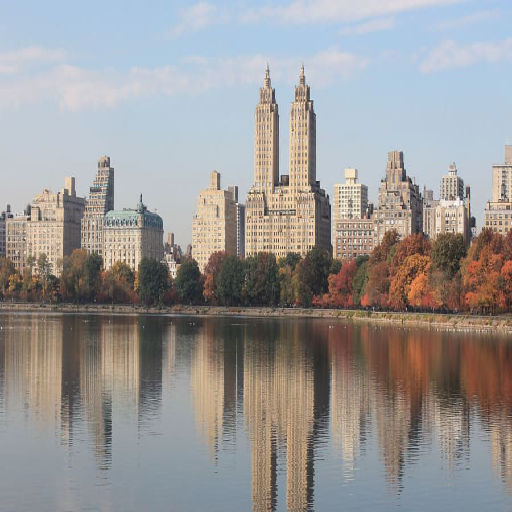

In [33]:
height=512
width=512

content_image_path = 'central_park.jpg'
content_image = Image.open(content_image_path)
#content_image=content_image.rotate(270)
content_image = content_image.resize((width, height))
content_image

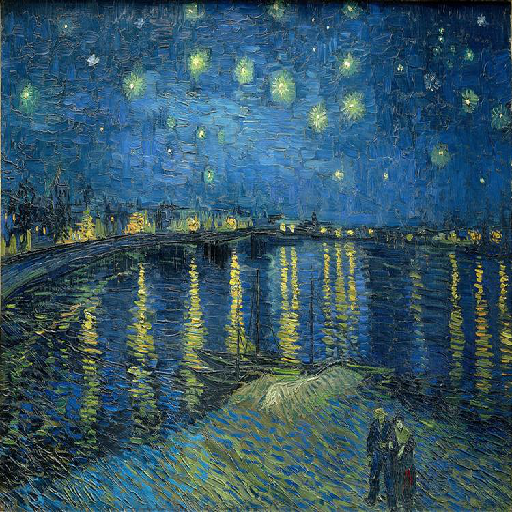

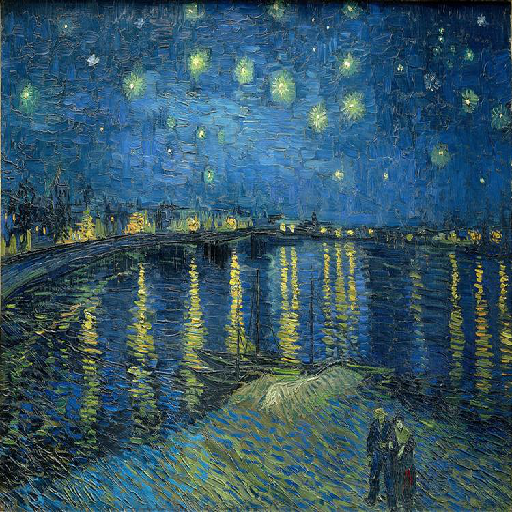

In [34]:
style_image_path = 'starry_night.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [0]:
def get_means(content_image_path,style_image_path):
  """This function will get means vector for normalization
  
  Arguments:
    content_image_path: the path of content image
    style_image_path: the path of style image
      
  Returns:
    returns means vector
  """
  c = Image.open(content_image_path)
  c = c.resize((width, height))  
  c_array=kp_image.img_to_array(c)
  s = Image.open(style_image_path)
  s = s.resize((width, height))  
  s_array=kp_image.img_to_array(s)
  return (np.mean(c_array,tuple(range(2)))+np.mean(s_array,tuple(range(2))))/2

In [0]:
#means = get_means(content_image_path,style_image_path)
means=[103.939, 116.779,123.68]

In [37]:
means

[103.939, 116.779, 123.68]

[103.939, 116.779, 123.68]

## Step 1: Read and preprocess data

In [0]:
def load_and_preprocess_img(image_path,height,width,means):
  """This function will load and resize image.
  
  Arguments:
    image_path: the path of image
    height: image height
    width: image width
    means: means vector for normalization so as to adjust contrast of style image and content image)
      
  Returns:
    returns image pixel numpy array and image itself
  """
  
  #load and resize
  img = Image.open(image_path)
  img = img.resize((width, height))  
  
  #get raw pixel array
  img_array=kp_image.img_to_array(img)  #range: 0-255
  
  #subtract mean vector
  #img_array -= means
  #img_array /= 127.5
  img_array = np.expand_dims(img_array, axis=0)
  img_array=tf.keras.applications.vgg16.preprocess_input(img_array)  #RGB ---> BGR and mean subtract
  
  return img_array,img

There is one thing to be pointed out that we subtract means vector from original images so as to somehow adjust the color difference between content image ans style image. This idea comes from Gatys paper. 

## Step 2: Build a model

In [0]:
def hidden_model(layers_content,layers_style):
  """This function will build a model which would output features from hidden layers that we want
  
  Arguments:
    layers_content: content layers name
    layers_style: style layers name
      
  Returns:
    returns model which outputs the hidden feature
  """
  #model = tf.keras.applications.vgg19.VGG19(input_shape=(512, 512, 3), include_top=False)
  model = tf.keras.applications.vgg16.VGG16(input_shape=(512, 512, 3), include_top=False)
  model.trainable = False
  content_outputs=[model.get_layer(l).output for l in layers_content]
  style_outputs=[model.get_layer(l).output for l in layers_style]
  outputs=content_outputs+style_outputs
  return models.Model(model.input, outputs) 

In [0]:
model = tf.keras.applications.vgg16.VGG16(input_shape=(512, 512, 3), include_top=False)

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
__________

## Step 3: Compute loss

### Content Loss

In [0]:
def content_loss(comb_features,content_features):
  """This function will compute content loss
  
  Arguments:
    comb_features: combination image features
    content_features: content image features
      
  Returns:
    returns content loss
  """
  return tf.reduce_sum(tf.square(comb_features-content_features))

### Style Loss

In [0]:
def gram_matrix(feature_tensor):
  """This function will compute gram matrix based on Gatys paper
  
  Arguments:
    feature_tensor: feature tensor
      
  Returns:
    returns gram matrix
  
  Note:
    In order to reduce computation somehow, we could normalize loss. 
    This idea comes from tensorflow tutorial:
    https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  
  """
  channel = int(feature_tensor.shape[-1])
  feature_2d=feature_tensor[0,:,:,:]
  #feature_2d=tf.keras.backend.permute_dimensions(feature_2d,(2,0,1))
  feature_2d=tf.reshape(feature_tensor, [-1, channel])
  #n=feature_2d.shape[0]
  feature_2d=tf.matmul(feature_2d, feature_2d, transpose_a=True)
  #return feature_2d/tf.cast(n,tf.float32)
  return feature_2d

In [0]:
def style_loss_per_layer(comb_features,style_features):
  """This function will compute style loss for a specific layer
  
  Arguments:
    comb_features: combination image features
    style_features: style image features
      
  Returns:
    returns style loss for each layer
  
  """
  comb_gram=gram_matrix(comb_features)
  style_gram=gram_matrix(style_features)
  _,h,w,N,=style_features.shape
  #M=tf.multiply(h,w).numpy()
  M=tf.cast(tf.multiply(h,w),tf.float32)
  #N=tf.cast(N,tf.float32)
  M2=tf.pow(tf.cast(M,tf.float32),2)
  N2=tf.pow(tf.cast(N,tf.float32),2)
  norm=tf.divide(1,tf.multiply(4,tf.multiply(M2,N2)))
  style_l=tf.reduce_sum(tf.square(style_gram-comb_gram))
  return tf.multiply(norm,style_l)
  #return style_l

In [0]:
def style_loss(comb_features_lst,style_features_lst):
  """This function will compute total style loss
  
  Arguments:
    comb_features_lst: combination image features for many layers
    style_features_lst: style image features for many layers
      
  Returns:
    returns total style loss
  
  """
  style_score=0
  style_weight_per_layer=1.0/float(len(style_features_lst))  #uniformly
  for i in range(len(style_features_lst)):
    style_loss_single=style_loss_per_layer(comb_features_lst[i],style_features_lst[i])
    style_score += style_weight_per_layer * style_loss_single
  return style_score

### Variation Loss

In [0]:
def variation_loss(comb_image,height,width,beta):
  """This function will compute variation loss
  
  Arguments:
    comb_image: combination image 
    height: image height
    width: image width
      
  Returns:
    returns variation loss
  
  Note: variation loss is a regularisation term that encourages spatial smoothness.
        this idea comes from this paper: https://arxiv.org/abs/1412.0035
  
  """
  a = tf.square(comb_image[:, :height-1, :width-1, :] - comb_image[:, 1:, :width-1, :])   
  b = tf.square(comb_image[:, :height-1, :width-1, :] - comb_image[:, :height-1, 1:, :])
  return tf.reduce_sum(tf.pow(a + b, beta/2))

### Total loss

In [0]:
def compute_loss(model,init_image,content_image,style_image,
                 content_weight,style_weight,variation_weight,beta):
  """This function will compute total loss
  
  Arguments:
    model: the hidden model we build
    init_image: initial image(numpy array)
    content_image: content image(numpy array)
    style_image: style image(numpy array)
    content_weight, style_weight, variation_weight: weights
    beta: beta parameter for variation loss
      
  Returns:
    returns total loss
  
  """
  content_features=model(content_image)[0]
  style_features_lst=model(style_image)[1:]
  init_features=model(init_image)
  loss_c=content_loss(init_features[0],content_features)
  loss_s=style_loss(init_features[1:],style_features_lst)
  loss_var=variation_loss(init_image,height,width,beta)
  l=content_weight*loss_c+style_weight*loss_s+variation_weight*loss_var
  return l
  #return content_weight*loss_c+style_weight*loss_s

## Step 4: Compute gradients

In [0]:
def compute_grads(par):
  """This function will compute grads w.r.t initial image
  
  Arguments:
    par: a set which contains parameters
      
  Returns:
    returns gradients and loss
    
  Note:
    The idea of relu(gradients) comes from Gatys paper.
  """
  with tf.GradientTape() as tape:
    par['init_image']=par['init_image'].reshape((1, height, width, 3))
    par['init_image'] = tfe.Variable(par['init_image'], dtype=tf.float32)
    l = compute_loss(**par)
    g = tape.gradient(l, par['init_image'])
  return g.numpy().reshape([-1,]).astype('float64'),l

## Step 5: Compile Loss and Gradients

In [0]:
class loss_grads_compile():
  
  """This class will compile loss and gradients for optimization
  """
  
  def __init__(self):
    self.grads=None
    self.loss=None
    
  def get_loss(self,x):
    par={'model': model,
         'init_image': x,
         'content_image': content_image,
         'style_image': style_image,
         'content_weight':content_weight,
         'style_weight': style_weight,
         'variation_weight':variation_weight,
         'beta':beta}
    #x = x.reshape((1, height, width, 3))
    #x = tfe.Variable(x, dtype=tf.float32)
    grads_value,loss_value=compute_grads(par)
    self.loss=loss_value
    self.grads=grads_value
    return self.loss
    
  def get_grads(self,x):
    grads_value=np.copy(self.grads)
    self.loss=None
    self.grads=None
    return grads_value

In [0]:
compiler=loss_grads_compile()

In [51]:
import numpy as np
init_image = (np.random.uniform(0, 255, (512, 512, 3)))-128.
init_image = np.expand_dims(init_image,axis=0)
init_image.reshape([-1,])

array([   9.34917836,   27.07468956,   -1.06560035, ...,   99.40243325,
       -113.18803194,  -36.99382894])

array([ 91.03674963, -10.10665094, -57.09528129, ...,  85.13773528,
       -72.55945277,   9.16056612])

## Step 5: Transfer Style

In [0]:
def transfer_style(height,width,init_way,means,layers_content,layers_style,
                   content_weight,style_weight,variation_weight,beta,iterations):
  
  """This function will implement style transfer
  
  Arguments:
    height: image height
    width: image width
    init_way: the way of initializing our combine image
    means: means vector for normalization
    layers_content: content layers name
    layers_style: style layers name
    content_weight, style_weight, variation_weight: weights
    beta: beta parameter for variation loss
    iterations: the number of iterations
    
  Returns:
    returns combination image
    
  Note: Display part idea comes from tensorflow tutorial: 
        https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb
  """
  
  if init_way=='noise':
    init_image = (np.random.uniform(0, 255, (height, width, 3)))-128.
    init_image = np.expand_dims(init_image,axis=0)
  elif init_way=='content':
    init_image = content_image.copy()
  elif init_way=='style':
    init_image = style_image.copy()
  
  global_step = tf.train.get_or_create_global_step()
  writer = tf.contrib.summary.create_file_writer('./alpha')
  
  #optimize and show results
  imgs = []
  best_loss, best_img = float('inf'), None
  
  with writer.as_default(), tf.contrib.summary.always_record_summaries():
    for i in range(iterations):
      start_time = time.time()
      init_image, min_val, info = fmin_l_bfgs_b(compiler.get_loss, init_image.reshape([-1,]),
                                       fprime=compiler.get_grads, maxfun=20)
      global_step.assign(i)
      tf.contrib.summary.scalar('loss',min_val)
      end_time = time.time()
    
      d = min_val < best_loss
      if d.numpy()[0]:
        best_loss = min_val.numpy()[0]
        best_img = init_image.copy()
        best_img= best_img.reshape((height, width, 3))
        best_img += means
        best_img = best_img[:, :,::-1]
        #best_img += means
        best_img = np.clip(best_img, 0, 255).astype('uint8')
    
      if i % 1==0:
        img_array= init_image.copy()
        img_array= img_array.reshape((height, width, 3))
        img_array += means
        img_array = img_array[:, :,::-1]
        #img_array += means
        img_array = np.clip(img_array, 0, 255).astype('uint8')
        imgs.append(img_array)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(img_array))
        print('Iteration: '+str(i))
        print('Loss value:' + str(min_val.numpy()[0]))
        print('Iteration %d completed in %ds' % (i, end_time - start_time))
      
    
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(10,15))
    for i,img in enumerate(imgs):
        plt.subplot(4,3,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([]) 
      
  return best_loss, best_img

In [0]:
# Tuning part
layers_content = ['block2_conv2']
layers_style = ['block1_conv2', 'block2_conv2','block3_conv2', 'block4_conv2','block5_conv2']
content_weight=0.025,
style_weight=400,
variation_weight=3,
beta=2.5
init_way='noise'
iterations=10

In [0]:
# Don't Modify it!
#get hidden model
model = hidden_model(layers_content,layers_style)
for layer in model.layers:
  layer.trainable = False
  
#create white noise image and load target images
content_image,_= load_and_preprocess_img(content_image_path,height,width,means)
style_image,_= load_and_preprocess_img(style_image_path,height,width,means)

#change RGB to BGR
#content_image = content_image[:, :, :, ::-1]
#style_image = style_image[:, :, :, ::-1]

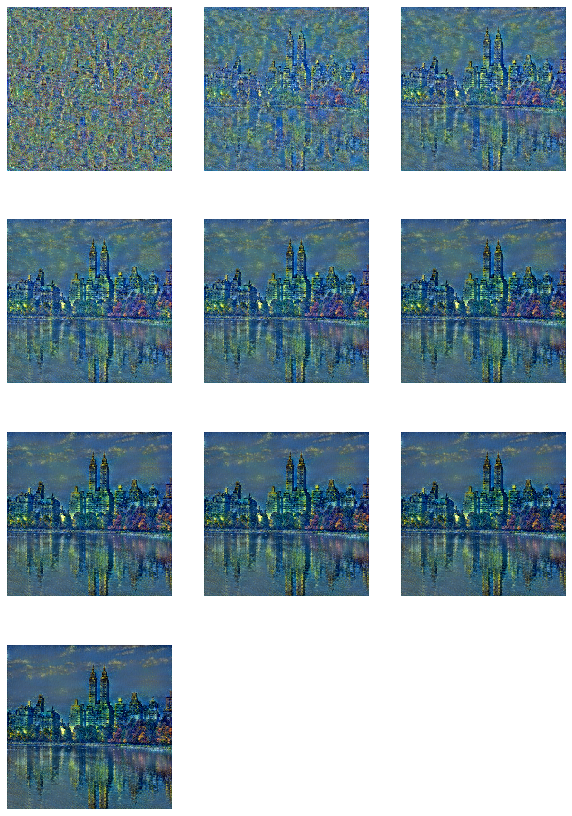

In [55]:
best_loss,best_img =transfer_style(height,width,init_way,means,layers_content,layers_style,
                                  content_weight,style_weight,variation_weight,beta,iterations)

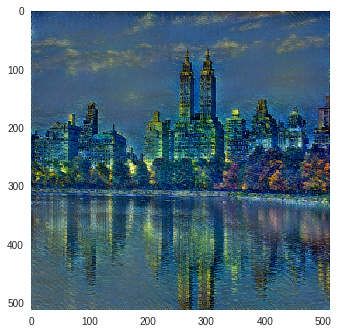

In [59]:
plt.imshow(best_img)
plt.grid(False)

In [0]:
final_img = Image.fromarray(best_img)
final_img.save("starry_central_park.jpg")

In [58]:
LOG_DIR = './alpha/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
    )
    
# Download and unzip ngrok - you will only need to do this once per session
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip
    
get_ipython().system_raw('./ngrok http 6006 &')
    
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
    
# #writer.close()

--2018-12-17 08:37:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.232.40.183, 34.238.3.58, 34.232.181.106, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.232.40.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.5’

ngrok-stable-linux- 100%[===================>]   5.11M  19.5MB/s    in 0.3s    

2018-12-17 08:37:09 (19.5 MB/s) - ‘ngrok-stable-linux-amd64.zip.5’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   
https://e79278d3.ngrok.io
--2018-12-17 08:40:39--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.55.191.55, 52.86.186.182, 52.22.145.207, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.55.191.55|:443... connected.
HT

## TO DO: Tune Parameters

* Content loss: the specific layer used to calculate content loss.
* Style loss: 
 * the layers used to calculate style loss.
 * weights for each layer (uniform or different weights) .
* Loss: weights for content loss, style loss and variation loss.
* Variation loss: smooth parameter—beta.
* Init_image: how could we initial image? 
* Optimizer: compare different optimizers.

---

Done(12.2):

* Image Normalize: mean vector subtract. 
* 1 to 1 Image: Change another two images for tuning process.
* `variation_loss`: square sum
* Image Normalize: mean subtract like 2015 original paper. 
* Model: VGG16, VGG19, MobileNet and etc. (cannot be compared)
